**SPEECH EMOTION RECOGNITION**

SAS final assignement

Tonny Le 13226754

Voor de laatste opdracht heb ik gekozen voor het herkennen van emoties op basis van de stem, wat ook gelijk de hoofdvraag is: In hoeverre is het mogelijk om een model te maken die de emotie van een spreker kan herkennen?

Als model heb ik gekozen voor een LSTM, aangezien deze modellen goed zijn in het behandelen van reeksen data, wat ook bij ons het geval is, data die ingesproken wordt. Ook word gaat mijn voorkeur boven de CNN omdat die voor mij nog een beetje een 'black box' is.

***DATA***

Als data heb ik gekozen voor de Revdess dataset van Zenodo. Deze data is gratis te verkrijgen onder de licentie genaamd *Creative Commons Attribution Non Commercial Share Alike 4.0 International*. Hierbij kunnen mensen de data gratis gebruiken voor niet commenrcieel gebruik. 

Om de data te kunnen gebruiken is het zip bestand downloaden van Canvas voldoende, uploaden naar de drive is optioneel maar maakt het gebruik van de notebook gemakkelijker, hieronder is de cell met de 'Root' variabele, wat veranderd kan worden voor de eigen locatie van de Revdess map.

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive')

Root = "/content/drive/MyDrive/SAS/Ravdess"
os.chdir(Root)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import librosa
import pandas as pd
import tensorflow.keras as keras
import seaborn as sns
import matplotlib.pyplot as plt



Als data preprocessing heb ik ervoor gekozen om niet de volledige mfcc te nenen die librosa geeft, maar het gemiddelde van de 100. Dit maakt het invullen in de LSTM makkelijker, nu elk datapunt een reeks van 100 getallen is.

In [3]:
def get_mfcc(file):
    y, sr = librosa.load(file)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=100).T, axis=0)
    return mfcc

Hieronder worden de mfcc's berekent, en de data wordt gelijk gelabeled met de desbetreffende emotie. Verder wordt elk datapunt (mfcc) gelabeld in de features lijst (variabele y) op de zogenoemde *one hot encoding* manier, wat het keras LSTM model om vraagt als input features.

In [4]:
# Grab a coffee, as this'll take ~5 min
emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
file_list = os.listdir(Root)
data = []
mfcc = []
y = []

for i in range(len(file_list)):
    idx = int(file_list[i][6:8])-1
    emotion = emotions[idx]
    data.append(emotion)
    mfcc.append(get_mfcc(file_list[i]))
    emo_idx = np.zeros(8)
    emo_idx[idx] = 1
    y.append(emo_idx)

In [5]:
df = pd.DataFrame(list(zip(file_list, data, mfcc)),
                  columns =['file', 'emotion', 'mfcc'])
df

,file,emotion,mfcc
0,03-01-06-02-01-02-08.wav,fearful,"[-454.74567, 24.271505, -24.567669, 8.734999, ..."
1,03-01-07-01-01-01-08.wav,disgust,"[-680.01184, 65.156494, 10.326706, 17.873919, ..."
2,03-01-07-01-02-01-08.wav,disgust,"[-672.0514, 62.881516, 14.926428, 15.036368, 5..."
3,03-01-06-02-01-01-08.wav,fearful,"[-437.0863, 22.35926, -20.632498, 8.388019, -6..."
4,03-01-06-01-01-01-08.wav,fearful,"[-534.0606, 47.17699, -24.207684, 8.500984, -0..."
...,...,...,...
1455,03-01-04-02-01-02-08.wav,sad,"[-632.6508, 59.079807, -6.028909, 18.05034, 7...."
1456,03-01-05-01-01-02-08.wav,angry,"[-541.0017, 47.75792, -1.959699, 13.853453, -8..."
1457,03-01-05-01-02-01-08.wav,angry,"[-601.5641, 48.488518, 6.8219714, 12.992502, -..."
1458,03-01-04-02-02-01-08.wav,sad,"[-666.0346, 60.911926, -2.652072, 17.441277, 8..."


Hieronder een distributie bar plot van de emoties in de dataset. Opvallend is het aantal neutraal ingesproken bestanden, maar omdat dit een klein deel van de totale data is, en we geïnteresseerd zijn in de emoties, is het niet een groot probleem.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


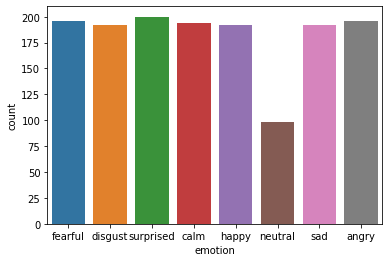

In [6]:
sns.countplot(df['emotion'])

De gebruikte data voor ons model, 1460 datapunten van mfcc data dat als shape (100, 1)

In [7]:
X = np.array([i for i in df['mfcc']])
X = np.expand_dims(X, -1)
X.shape

(1460, 100, 1)

Onze target data, geformat via de one hot encoding. 

In [8]:
y = np.array(y)
y.shape

(1460, 8)

In [9]:
print(emotions)
print(y[0])
df.head(2)

['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
[0. 0. 0. 0. 0. 1. 0. 0.]


,file,emotion,mfcc
0,03-01-06-02-01-02-08.wav,fearful,"[-454.74567, 24.271505, -24.567669, 8.734999, ..."
1,03-01-07-01-01-01-08.wav,disgust,"[-680.01184, 65.156494, 10.326706, 17.873919, ..."


Hieronder is het model dat ik heb opgesteld, ik heb gekozen voor een extra dropout layers, dit zou een potentiele overfitting voorkomen, omdat dit per laag een paar nodes overslaat. Persoonlijk dacht ik dat dit wel een een goede toevoeging geeft, aangezien vaak hetzelfde zinnetje wordt ingesproken. De laatste laag heeft 8 lagen, want er zijn 8 verschillende emoties, met de softmax as activatie functie, die een waarde tussen 0 en 1 geeft voor de voorspelling.

In [10]:
model = keras.Sequential([
    keras.layers.LSTM(128, return_sequences=False, input_shape=(100, 1)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(8, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
Total params: 77,160
Trainable params: 77,160
Non-traina

***MEMORY FOOTPRINT***

Het totale aantal parameters is volgens de summary 77.160. Omdat de mfcc's in de data als bestandstype float worden bewaard, is het totale geheugen dat er nodig is voor 1 mfcc 77160 * 4. Dit levert op ongeveer 0.30 mb, en het hele model levert dus 77160 * 4 * 1460 levert op ongeveer 423 mb.

In [11]:
fit = model.fit(
    X, y, 
    validation_split=0.2, 
    batch_size=128, 
    shuffle=True,
    epochs=100
)

Epoch 1/100
10/10 [==============================] - 4s 71ms/step - loss: 2.0744 - accuracy: 0.1550 - val_loss: 2.0576 - val_accuracy: 0.1575
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 2.0597 - accuracy: 0.1558 - val_loss: 2.0322 - val_accuracy: 0.1473
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 2.0506 - accuracy: 0.1575 - val_loss: 2.0286 - val_accuracy: 0.1952
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 2.0376 - accuracy: 0.1721 - val_loss: 2.0054 - val_accuracy: 0.1747
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.9995 - accuracy: 0.1943 - val_loss: 2.0229 - val_accuracy: 0.1849
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.9903 - accuracy: 0.1926 - val_loss: 1.9661 - val_accuracy: 0.1952
Epoch 7/100
10/10 [==============================] - 0s 12ms/step - loss: 1.9677 - accuracy: 0.2200 - val_loss: 1.9575 - val_accuracy: 0.1747
Epoch 

***RESULTATEN***

Het model hierboven levert een accuracy op van ongeveer ~47 %. Dit is het resultaat van een aantal keren trial en error qua parameters, ik had als eerste laag een model van 256 als input, 128 en 64 als dense layers, en dat leverde lagere resultaten op (35%). Varianten hierval leverden ook lagere resultaten op. Ook probeerde ik een verschillend aantal denselayers wat ook een lager resultaat geeft. De plot hieronder laat de loss zien die over de tijd van het bovenstaande model.

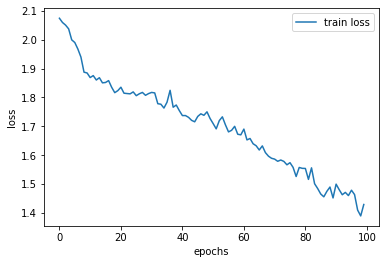

In [12]:
loss = fit.history['loss']
plt.plot(list(range(100)), loss, label='train loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

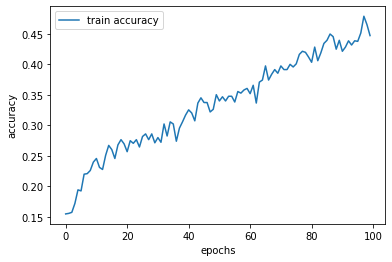

In [13]:
acc = fit.history['accuracy']

plt.plot(list(range(100)), acc, label='train accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

***DISCUSSIE & CONCLUSIE***

Gezien de resultaten met een nauwkeurigheid van rond de 50% denk ik dat dit model wel veel verbetering kan hebben. Ikzelf heb van de mfcc's maar honderd waardes genomen, maar een model kan getrained worden op basis van de gehele mfcc. Terugblikkend op de hoofdvraag, in hoeverre is het mogelijk om een model te maken dat emotie kan herkennen van een spreker, is dit model niet voldoende om gebruikt te worden in de realiteit. Om een goed model te kunnen maken, moet het hoogstwaarschijnlijk voor elke emotie duizenden traindata hebben. Dit komt ook omdat mensen niet rationeel zijn, en elke stem ook anders is, en het accent ook een rol speelt. Misschien met een dataset die aantallen miljoenen groot is, kan er een model worden getraind die een redelijke nauwkeurigheid heeft. De Revdess dataset van de canvas site heeft maar 1460 datapunten, en gezien de complexiteit van dit probleem is een nauwkeurigheid van 47% niet eens zo slecht. Het model van mij is ook een simpel LSTM met drie dense layers, maar een beter model zou misschien ook een Language model kunnen combineren voor betere nauwkeurigheid.